### 02a\_coverage (lightweight) — ARP response coverage & scene→A\&E conveyance

Quantify the **% of people** reachable within **Ambulance Response Programme (ARP)** targets using travel time from the **nearest ambulance station** to each LSOA: **7** (Cat-1 mean), **15** (Cat-1 p90), **18** (Cat-2 mean), **40** (Cat-2 p90).
Also map **scene → A\&E conveyance** bands (default **30/45/60 min**) from each LSOA to the **nearest acute hospital** — a *geographic potential* measure (not an operational target).

**Thresholds in this notebook**

* **Response (ARP):** `RESP = {"cat1": {"mean": 7, "p90": 15}, "cat2": {"mean": 18, "p90": 40}, ...}`
  Convenience tuple: `RESPONSE_THRESHOLDS = (7, 15, 18, 40)`.
* **Handover policy (not mapped here):** `HANDOVER = {"target": 15, "breach": 30, "severe": 60}`.
* **Scene→A\&E drive (configurable):** `SCENE_TO_AE_THRESHOLDS = (30, 45, 60)`.

**Method (population-weighted)**

* For each LSOA, compute minimum **station → LSOA** travel time (response) and minimum **LSOA → acute** travel time (conveyance).
* Coverage at time *t* = population living in LSOAs with travel time ≤ *t* ÷ total population.
* Maps overlay **stations (▲)** and **acute hospitals (●)**; polygons are in **EPSG:27700**.

**Data**

* Uses the Cornwall ICB test slice from `01_develop_test_data_cornwall_icb` (lookup, continuous-age GPKG, LSOA↔LSOA travel matrix; optional RUC/IMD) under `data/raw/test_data_ICB_level/`.

**Outputs**

* KPI printouts for response and conveyance thresholds.
* PNG maps (binary coverage with overlays) saved to `.../data/raw/test_data_ICB_level/maps/`.
* `coverage_summary_light.csv` for downstream dashboards.


In [8]:
# Step 0 — Imports, params (updated: ARP + handover thresholds)
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Paths
DATA_ROOT = Path(
    "/Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/"
    "GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level"
)

# Files
LOOKUP_CSV   = DATA_ROOT / "cornwall_icb_lsoa_lookup.csv"
AGE_GPKG     = DATA_ROOT / "demographics_age_continuous_icb.gpkg"
AGE_LAYER    = "LSOA_continuous_age_icb"
TRAVEL_CSV   = DATA_ROOT / "travel_matrix_lsoa_icb.csv"
STATIONS_CSV = DATA_ROOT / "ambulance_stations_icb.csv"
ACUTE_CSV    = DATA_ROOT / "acute_hospitals_icb.csv"   # overlay optional

# --- Targets / thresholds ----------------------------------------------------
# ARP response standards (minutes)
RESP = {
    "cat1": {"mean": 7,  "p90": 15},
    "cat2": {"mean": 18, "p90": 40},
    # optional for completeness:
    "cat3": {"p90": 120},
    "cat4": {"p90": 180},
}
# Convenience tuple for KPI lookups used in this notebook
RESPONSE_THRESHOLDS = (RESP["cat1"]["mean"], RESP["cat1"]["p90"],
                       RESP["cat2"]["mean"], RESP["cat2"]["p90"])  # -> (7, 15, 18, 40)

# Hospital handover/turnaround (NOT scene→A&E drive time)
HANDOVER = {"target": 15, "breach": 30, "severe": 60}
HANDOVER_THRESHOLDS = (HANDOVER["target"], HANDOVER["breach"], HANDOVER["severe"])  # (15, 30, 60)

# Scene→A&E conveyance (geographic potential only; no national target)
# Keep if you want to map the drive leg; adjust locally if desired.
SCENE_TO_AE_THRESHOLDS = (30, 45, 60)

# Optional blue-light factors applied to car travel times (1.0 = off)
BLUE_LIGHT_FACTOR_RESPONSE = 1.0
BLUE_LIGHT_FACTOR_CONVEY   = 1.0

# Display prefs
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 120)


In [9]:
# Step 1 — Load core data fast (few columns, light dtypes; aligned to lookup)
# ----------------------------------------------------------------------------
# LSOA lookup (defines universe)
lookup = pd.read_csv(
    LOOKUP_CSV,
    usecols=["lsoa_code", "lsoa_name"],
    dtype={"lsoa_code": "string", "lsoa_name": "string"},
    memory_map=True,
)
lsoa_index = lookup["lsoa_code"].astype("string")

# Age/geometry (subset to essentials; ensure EPSG:27700)
age_gdf = gpd.read_file(AGE_GPKG, layer=AGE_LAYER)
age_gdf["lsoa_code"] = age_gdf["lsoa_code"].astype("string")

# Keep only what we need (geometry + name + any digit-named age columns or population_total)
age_cols = [c for c in age_gdf.columns if str(c).isdigit()]
keep_cols = ["lsoa_code", "lsoa_name", "geometry"] + (["population_total"] if "population_total" in age_gdf.columns else age_cols)
age_gdf = age_gdf[keep_cols]

# CRS normalisation (lightweight)
if age_gdf.crs is None or str(age_gdf.crs).upper() != "EPSG:27700":
    age_gdf = age_gdf.to_crs("EPSG:27700")

# Travel matrix (only needed cols; categorical IDs for faster groupby)
travel = pd.read_csv(
    TRAVEL_CSV,
    usecols=["origin_lsoa", "dest_lsoa", "time_car_min"],
    dtype={"origin_lsoa": "string", "dest_lsoa": "string", "time_car_min": "float32"},
    memory_map=True,
)
travel["origin_lsoa"] = travel["origin_lsoa"].astype("category")
travel["dest_lsoa"]   = travel["dest_lsoa"].astype("category")

# Population (prefer pre-aggregated; else sum digit-named age columns)
if "population_total" in age_gdf.columns:
    pop = age_gdf.set_index("lsoa_code")["population_total"].astype("float32")
else:
    pop = (
        age_gdf.set_index("lsoa_code")[age_cols]
        .apply(pd.to_numeric, errors="coerce")
        .fillna(0)
        .sum(axis=1)
        .astype("float32")
    )
pop.name = "population_total"

# Align population to lookup’s LSOA universe (order + guarantees for downstream)
pop = pop.reindex(lsoa_index).fillna(0)

# Geometry convenience (GeoDataFrame indexed by LSOA, aligned to lookup order)
lsoa_g = (
    age_gdf[["lsoa_code", "lsoa_name", "geometry"]]
    .drop_duplicates("lsoa_code")
    .set_index("lsoa_code")
    .reindex(lsoa_index)
)

# Tiny, helpful prints (no heavy QA)
print(f"[OK] LSOAs: {len(lsoa_index):,} | CRS: {lsoa_g.crs}")
print(f"[OK] Travel rows: {len(travel):,} | "
      f"Unique origins: {travel['origin_lsoa'].cat.categories.size:,} | "
      f"Unique dests: {travel['dest_lsoa'].cat.categories.size:,}")
print(f"[OK] Population total: {int(pop.sum()):,}")


[OK] LSOAs: 336 | CRS: EPSG:27700
[OK] Travel rows: 112,560 | Unique origins: 336 | Unique dests: 336
[OK] Population total: 575,628


In [13]:
# Step 2 — Load stations & acute (prefer LSOA codes; fall back to lat/lon/BNG)

def load_sites_fast(
    path: Path,
    lsoa_g: gpd.GeoDataFrame,
    id_cols=("station_id", "site_id", "code", "ods_code", "name"),
) -> pd.DataFrame | None:
    """
    Standardise site tables to:
      - id (string)
      - lsoa_code (string)
      - optional lat, lon (float) for true-point overlays

    Accepts any of:
      • lsoa_code
      • lsoa21cd
      • latitude + longitude (WGS84)
      • bng_e + bng_n (EPSG:27700)
    Returns None if file missing or no recognised schema (lightweight behaviour).
    """
    if not path.exists():
        return None

    df = pd.read_csv(path)
    if df.empty:
        return None

    df.columns = [c.strip().lower() for c in df.columns]

    # Choose a stable ID
    for c in id_cols:
        if c in df.columns:
            df["id"] = df[c].astype("string")
            break
    else:
        df["id"] = [f"X{i:03d}" for i in range(1, len(df) + 1)]

    # Case A: direct LSOA code
    if "lsoa_code" in df.columns and df["lsoa_code"].notna().any():
        out = df.loc[df["lsoa_code"].notna(), ["id", "lsoa_code"]].copy()
        out["lsoa_code"] = out["lsoa_code"].astype("string")

    # Case B: lsoa21cd
    elif "lsoa21cd" in df.columns and df["lsoa21cd"].notna().any():
        out = df.loc[df["lsoa21cd"].notna(), ["id", "lsoa21cd"]].copy()
        out = out.rename(columns={"lsoa21cd": "lsoa_code"})
        out["lsoa_code"] = out["lsoa_code"].astype("string")

    # Case C: latitude/longitude
    elif any(c in df.columns for c in ("lat", "latitude")) and any(c in df.columns for c in ("lon", "longitude")):
        lat_col = "lat" if "lat" in df.columns else "latitude"
        lon_col = "lon" if "lon" in df.columns else "longitude"
        g = gpd.GeoDataFrame(
            df[["id", lat_col, lon_col]].copy(),
            geometry=gpd.points_from_xy(
                pd.to_numeric(df[lon_col], errors="coerce"),
                pd.to_numeric(df[lat_col], errors="coerce"),
            ),
            crs="EPSG:4326",
        ).to_crs(lsoa_g.crs)
        joined = gpd.sjoin(g, lsoa_g[["geometry"]], how="left", predicate="within")
        out = pd.DataFrame(
            {
                "id": joined["id"].astype("string"),
                "lsoa_code": joined["index_right"].astype("string"),  # lsoa_g index is lsoa_code
                "lat": pd.to_numeric(df[lat_col], errors="coerce"),
                "lon": pd.to_numeric(df[lon_col], errors="coerce"),
            }
        ).dropna(subset=["lsoa_code"])

    # Case D: OSGB easting/northing
    elif {"bng_e", "bng_n"}.issubset(df.columns):
        g = gpd.GeoDataFrame(
            df[["id", "bng_e", "bng_n"]].copy(),
            geometry=gpd.points_from_xy(
                pd.to_numeric(df["bng_e"], errors="coerce"),
                pd.to_numeric(df["bng_n"], errors="coerce"),
            ),
            crs="EPSG:27700",
        )
        # keep OSGB for join, also derive WGS84 for overlay
        joined = gpd.sjoin(g, lsoa_g[["geometry"]], how="left", predicate="within")
        wgs = g.to_crs("EPSG:4326")
        out = pd.DataFrame(
            {
                "id": joined["id"].astype("string"),
                "lsoa_code": joined["index_right"].astype("string"),
                "lat": wgs.geometry.y.values,
                "lon": wgs.geometry.x.values,
            }
        ).dropna(subset=["lsoa_code"])

    else:
        # No recognised columns → skip (lightweight)
        return None

    # Restrict to the LSOA universe (drop any stray codes)
    out = out.drop_duplicates("id")
    out = out[out["lsoa_code"].isin(lsoa_g.index)]

    # Light prints
    print(f"[OK] {path.name}: {len(out):,} sites mapped to {out['lsoa_code'].nunique():,} LSOAs")
    return out.reset_index(drop=True)


# Load sites (keeps lat/lon if available)
stations = load_sites_fast(STATIONS_CSV, lsoa_g, id_cols=("station_id", "code", "name"))
acute    = load_sites_fast(ACUTE_CSV,    lsoa_g, id_cols=("site_id", "ods_code", "name"))

# Arrays of LSOAs for min-time calcs
station_lsoas = stations["lsoa_code"].astype("string").unique() if stations is not None else np.array([], dtype=str)
acute_lsoas   = acute["lsoa_code"].astype("string").unique()    if acute    is not None else np.array([], dtype=str)

print(f"[INFO] Stations: {len(station_lsoas)} LSOAs | Acute: {len(acute_lsoas)} LSOAs")


[OK] ambulance_stations_icb.csv: 14 sites mapped to 14 LSOAs
[OK] acute_hospitals_icb.csv: 3 sites mapped to 3 LSOAs
[INFO] Stations: 14 LSOAs | Acute: 3 LSOAs


In [11]:
# Step 3 — Min travel times (vectorised, no loops; aligned to lsoa_index)

def min_time_from_any_origin(
    travel_df: pd.DataFrame,
    origins: np.ndarray,
    origin_key: str,
    dest_key: str,
    time_key: str = "time_car_min",
    align_index: pd.Index | None = None,
) -> pd.Series:
    """
    Filter travel_df to rows where `origin_key` ∈ origins, then take min by `dest_key`.
    Returns a float32 Series indexed by `align_index` (LSOA universe) if provided.
    """
    if origins is None or len(origins) == 0:
        return pd.Series(index=(align_index if align_index is not None else lsoa_index), dtype="float32")

    mask = travel_df[origin_key].isin(origins)
    if not mask.any():
        return pd.Series(index=(align_index if align_index is not None else lsoa_index), dtype="float32")

    df = travel_df.loc[mask, [dest_key, time_key]]
    s = df.groupby(dest_key, observed=True)[time_key].min().astype("float32")
    if align_index is not None:
        s = s.reindex(align_index)
    return s

# Response: from any station (origins) → each LSOA (destinations)
resp_times = (
    min_time_from_any_origin(
        travel_df=travel,
        origins=station_lsoas,
        origin_key="origin_lsoa",
        dest_key="dest_lsoa",
        align_index=lsoa_index,
    )
    * np.float32(BLUE_LIGHT_FACTOR_RESPONSE)
)

# Conveyance (scene → A&E drive): from each LSOA (origins) → any acute (destinations)
# Filter by hospital destinations, then min by origin
tmp = travel.rename(columns={"origin_lsoa": "o", "dest_lsoa": "d"})
conv_times = (
    min_time_from_any_origin(
        travel_df=tmp,
        origins=acute_lsoas,
        origin_key="d",   # keep rows whose DESTINATION is a hospital LSOA
        dest_key="o",     # then min by ORIGIN (home LSOA)
        align_index=lsoa_index,
    )
    * np.float32(BLUE_LIGHT_FACTOR_CONVEY)
)


In [12]:
# Step 4 — KPIs (population-weighted) using ARP + scene→A&E thresholds

def pct_covered(times: pd.Series, thresholds: tuple[int, ...]) -> dict[int, float]:
    # Treat missing times as not covered (mask is False)
    return {t: float(pop[(times <= t)].sum() / pop.sum()) if pop.sum() else 0.0 for t in thresholds}

resp_kpis = pct_covered(resp_times, RESPONSE_THRESHOLDS)           # (7, 15, 18, 40)
conv_kpis = pct_covered(conv_times, SCENE_TO_AE_THRESHOLDS)        # (30, 45, 60) for the drive leg

def _pct(x: float) -> str: return f"{100*x:,.1f}%"

print("[RESULT] Response coverage (ARP, ≤ minutes):",
      ", ".join([f"{t}: {_pct(resp_kpis[t])}" for t in RESPONSE_THRESHOLDS]))

if len(acute_lsoas) == 0:
    print("[RESULT] Scene→A&E conveyance: no acute sites provided, skipping.")
else:
    print("[RESULT] Scene→A&E conveyance coverage (≤ minutes):",
          ", ".join([f"{t}: {_pct(conv_kpis[t])}" for t in SCENE_TO_AE_THRESHOLDS]))


[RESULT] Response coverage (ARP, ≤ minutes): 7: 30.8%, 15: 62.3%, 18: 75.2%, 40: 99.3%
[RESULT] Scene→A&E conveyance coverage (≤ minutes): 30: 51.8%, 45: 69.4%, 60: 79.0%


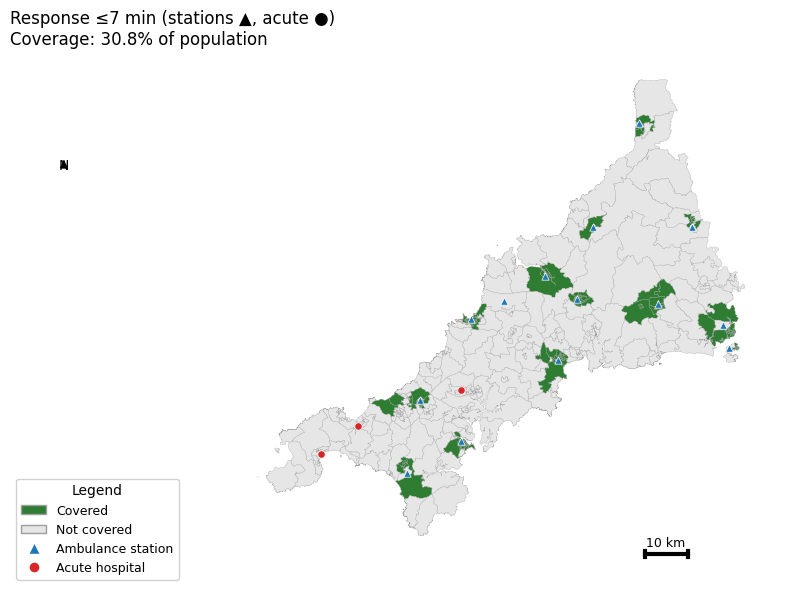

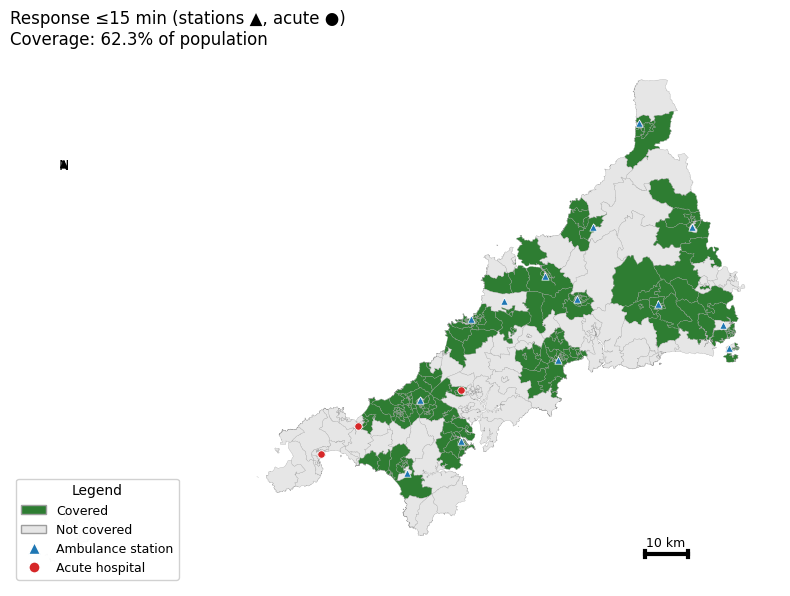

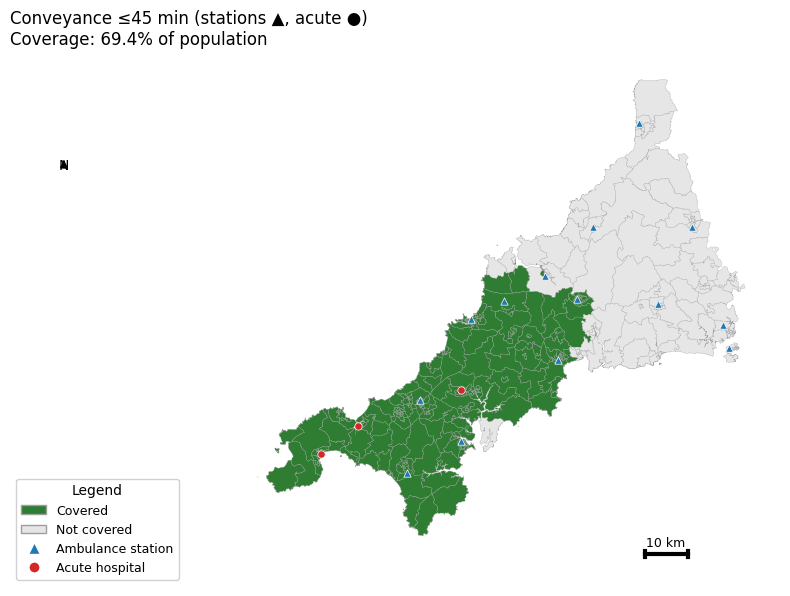

In [14]:
# Step 5 — Styled maps with overlays (binary coverage; dynamic thresholds)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# -------------------------
# Build binary flag columns
# -------------------------
g = lsoa_g.copy()

# Response (ARP): e.g., 7, 15, 18, 40
for t in RESPONSE_THRESHOLDS:
    g[f"resp_le_{t}"] = (resp_times <= t).fillna(False).astype("Int8")

# Scene→A&E conveyance (geographic leg): e.g., 30, 45, 60
for t in SCENE_TO_AE_THRESHOLDS:
    g[f"conv_le_{t}"] = (conv_times <= t).fillna(False).astype("Int8")

# -------------------------
# Colours & legend handles
# -------------------------
C_OVER, C_NCOVER = "#2E7D32", "#E6E6E6"  # covered / not covered
C_EDGE, C_STN, C_ACU = "#9E9E9E", "#1F77B4", "#D62728"

coverage_handles = [
    Patch(facecolor=C_OVER,   edgecolor=C_EDGE, label="Covered"),
    Patch(facecolor=C_NCOVER, edgecolor=C_EDGE, label="Not covered"),
]
point_handles = [
    Line2D([0], [0], marker="^", color="w", label="Ambulance station",
           markerfacecolor=C_STN, markeredgecolor="white", markersize=8, linewidth=0),
    Line2D([0], [0], marker="o", color="w", label="Acute hospital",
           markerfacecolor=C_ACU, markeredgecolor="white", markersize=8, linewidth=0),
]

# -------------------------
# Utilities
# -------------------------
def add_scalebar(ax, length_km: int = 10):
    """Simple scalebar (EPSG:27700 metres)."""
    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    L = length_km * 1000
    x_start = x1 - (x1 - x0) * 0.12 - L
    x_end   = x_start + L
    y = y0 + (y1 - y0) * 0.06
    ax.plot([x_start, x_end], [y, y], color="black", linewidth=3)
    tick_h = (y1 - y0) * 0.005
    ax.plot([x_start, x_start], [y - tick_h, y + tick_h], color="black", linewidth=3)
    ax.plot([x_end,   x_end],   [y - tick_h, y + tick_h], color="black", linewidth=3)
    ax.text((x_start + x_end) / 2, y + tick_h * 2, f"{length_km} km", ha="center", va="bottom", fontsize=9)

def add_north_arrow(ax):
    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    x = x0 + (x1 - x0) * 0.07
    y = y0 + (y1 - y0) * 0.78
    ax.annotate("N", xy=(x, y + 3500), xytext=(x, y),
                arrowprops=dict(arrowstyle="-|>", color="black", lw=1.5),
                ha="center", va="bottom", fontsize=10)

def cov_pct(geo: gpd.GeoDataFrame, col: str) -> float:
    covered = pop.loc[geo.index][geo[col] == 1].sum()
    return float(covered / pop.sum()) if pop.sum() else 0.0

def to_points_for_overlay(sites_df: pd.DataFrame, label: str) -> gpd.GeoDataFrame:
    """Use true lat/lon if present; otherwise polygon representative points."""
    if sites_df is None or sites_df.empty:
        return gpd.GeoDataFrame(columns=["id","type","geometry"], geometry="geometry", crs=lsoa_g.crs)

    cols = {c.lower() for c in sites_df.columns}
    if {"lat","lon"}.issubset(cols):
        df = sites_df.rename(columns=str.lower)
        gg = gpd.GeoDataFrame(
            df[["id","lat","lon"]],
            geometry=gpd.points_from_xy(df["lon"], df["lat"]),
            crs="EPSG:4326",
        ).to_crs(lsoa_g.crs)
        gg["type"] = label
        return gg[["id","type","geometry"]]

    # fallback to representative points
    reps = lsoa_g.geometry.representative_point()
    pts = reps.loc[sites_df["lsoa_code"].astype("string")].reset_index()
    pts.columns = ["lsoa_code", "geometry"]
    pts["id"] = sites_df["id"].astype("string").values
    pts["type"] = label
    return gpd.GeoDataFrame(pts, geometry="geometry", crs=lsoa_g.crs)[["id","type","geometry"]]

# Build overlay points once
stations_pts = to_points_for_overlay(stations, "Ambulance")
acute_pts    = to_points_for_overlay(acute,    "Acute")

def styled_binary_map(geo: gpd.GeoDataFrame, col: str, title: str, outfile: Path | None = None):
    """Pretty binary map with overlays, legend, scalebar, north arrow."""
    colors = np.where(geo[col].astype(int) == 1, C_OVER, C_NCOVER)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_axis_off()
    geo.plot(ax=ax, color=colors, edgecolor=C_EDGE, linewidth=0.2)

    if not stations_pts.empty:
        stations_pts.plot(ax=ax, markersize=28, marker="^", color=C_STN,
                          edgecolor="white", linewidth=0.5, zorder=4)
    if not acute_pts.empty:
        acute_pts.plot(ax=ax, markersize=28, marker="o", color=C_ACU,
                       edgecolor="white", linewidth=0.5, zorder=4)

    pct = cov_pct(geo, col)
    ax.set_title(f"{title}\nCoverage: {pct*100:,.1f}% of population", fontsize=12, loc="left", pad=8)
    ax.legend(handles=coverage_handles + point_handles, loc="lower left",
              frameon=True, framealpha=0.9, fontsize=9, title="Legend")

    add_north_arrow(ax)
    add_scalebar(ax, length_km=10)

    plt.tight_layout()
    if outfile is not None:
        fig.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ---------------------------------
# Render & (optionally) save images
# ---------------------------------
OUTMAP = DATA_ROOT / "maps"
OUTMAP.mkdir(exist_ok=True, parents=True)

# Response maps (pick any from RESPONSE_THRESHOLDS)
styled_binary_map(g, "resp_le_7",  "Response ≤7 min (stations ▲, acute ●)",  OUTMAP / "resp_le_7.png")
styled_binary_map(g, "resp_le_15", "Response ≤15 min (stations ▲, acute ●)", OUTMAP / "resp_le_15.png")
# Uncomment if you want the other ARP views too:
# styled_binary_map(g, "resp_le_18", "Response ≤18 min (stations ▲, acute ●)", OUTMAP / "resp_le_18.png")
# styled_binary_map(g, "resp_le_40", "Response ≤40 min (stations ▲, acute ●)", OUTMAP / "resp_le_40.png")

# Conveyance maps (scene→A&E drive leg)
styled_binary_map(g, "conv_le_45", "Conveyance ≤45 min (stations ▲, acute ●)", OUTMAP / "conv_le_45.png")
# Optional alternates to reflect your updated note:
# styled_binary_map(g, "conv_le_30", "Conveyance ≤30 min (stations ▲, acute ●)", OUTMAP / "conv_le_30.png")
# styled_binary_map(g, "conv_le_60", "Conveyance ≤60 min (stations ▲, acute ●)", OUTMAP / "conv_le_60.png")
